In [1]:
from pathlib import Path
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

ROOT = Path("..")
DATA_PROCESSED = ROOT / "data" / "processed" / "db1"
MODELS_DIR     = ROOT / "models" / "db1"
REPORTS_DIR    = ROOT / "reports" / "db1"
for p in [MODELS_DIR, REPORTS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [2]:
train_npz = DATA_PROCESSED / "dl_train_db1_raw.npz"
val_npz   = DATA_PROCESSED / "dl_val_db1_raw.npz"
test_npz  = DATA_PROCESSED / "dl_test_db1_raw.npz"

ztr = np.load(train_npz, allow_pickle=True)
zva = np.load(val_npz,   allow_pickle=True)
zte = np.load(test_npz,  allow_pickle=True)

Xtr, ytr = ztr["X"], ztr["y"]    # (N, T, C)
Xva, yva = zva["X"], zva["y"]
Xte, yte = zte["X"], zte["y"]
idx_to_label = ztr["idx_to_label"]
n_classes = len(idx_to_label)

print("Train:", Xtr.shape, "Val:", Xva.shape, "Test:", Xte.shape, "classes:", n_classes)

# Optional: keep data small but class-balanced for CPU
def stratified_cap(X, y, per_class=200, seed=0):
    rng = np.random.default_rng(seed)
    keep = []
    for c in np.unique(y):
        idx = np.where(y == c)[0]
        take = min(per_class, len(idx))
        if take > 0:
            keep.extend(rng.choice(idx, size=take, replace=False))
    keep = np.array(keep)
    return X[keep], y[keep]

Xtr, ytr = stratified_cap(Xtr, ytr, per_class=400, seed=0)
Xva, yva = stratified_cap(Xva, yva, per_class=100, seed=1)
Xte, yte = stratified_cap(Xte, yte, per_class=100, seed=2)

print("After caps — Train:", Xtr.shape, "Val:", Xva.shape, "Test:", Xte.shape)

Train: (312643, 50, 10) Val: (93436, 50, 10) Test: (93476, 50, 10) classes: 23
After caps — Train: (9200, 50, 10) Val: (2300, 50, 10) Test: (2300, 50, 10)


In [3]:
class EMGSeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i):
        return torch.from_numpy(self.X[i]), torch.tensor(self.y[i], dtype=torch.long)

BATCH_SIZE = 128
train_ds = EMGSeqDataset(Xtr, ytr)
val_ds   = EMGSeqDataset(Xva, yva)
test_ds  = EMGSeqDataset(Xte, yte)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

xb, yb = next(iter(train_loader))
xb.shape  # (B, T, C)

torch.Size([128, 50, 10])

# Positional encoding utils (sinusoidal) + Transformer model
We project channels → d_model, add positional encodings, run a stack of TransformerEncoderLayers, then aggregate over time (CLS token or mean pool).

In [5]:
import math
import torch
from torch import nn

class SinusoidalPosEnc(nn.Module):
    def __init__(self, d_model: int, max_len: int = 2000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)  # (T, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)  # not a parameter

    def forward(self, x):  # x: (B, T, d_model)
        T = x.size(1)
        return x + self.pe[:T].unsqueeze(0)  # broadcast over batch

class EMGTransformer(nn.Module):
    def __init__(
        self,
        n_features: int,     # input channels (C)
        n_classes: int,
        d_model: int = 128,
        n_heads: int = 4,
        n_layers: int = 3,
        dim_ff: int = 256,
        dropout: float = 0.2,
        use_cls_token: bool = True,
        pool: str = "mean",  # fallback if not using CLS; options: 'mean', 'max', 'last'
        ln_on_input: bool = True,
    ):
        super().__init__()
        self.use_cls = use_cls_token
        self.pool = pool

        self.proj = nn.Linear(n_features, d_model)
        self.in_ln = nn.LayerNorm(d_model) if ln_on_input else nn.Identity()
        self.posenc = SinusoidalPosEnc(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=dim_ff,
            dropout=dropout, batch_first=True, activation="gelu", norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        if self.use_cls:
            self.cls = nn.Parameter(torch.zeros(1, 1, d_model))  # learnable [CLS]
            nn.init.trunc_normal_(self.cls, std=0.02)

        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model), nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, n_classes),
        )

    def forward(self, x):  # x: (B, T, C)
        h = self.proj(x)          # (B, T, d_model)
        h = self.in_ln(h)
        h = self.posenc(h)        # add sinusoidal PE

        if self.use_cls:
            B = h.size(0)
            cls_tok = self.cls.expand(B, -1, -1)  # (B,1,d_model)
            h = torch.cat([cls_tok, h], dim=1)    # prepend CLS at t=0

        h = self.encoder(h)       # (B, T(+1), d_model)

        if self.use_cls:
            z = h[:, 0, :]        # CLS
        else:
            if self.pool == "mean":
                z = h.mean(dim=1)
            elif self.pool == "max":
                z, _ = h.max(dim=1)
            elif self.pool == "last":
                z = h[:, -1, :]
            else:
                raise ValueError("pool must be one of {'mean','max','last'}")

        return self.head(z)

In [6]:
n_features = Xtr.shape[2]
model = EMGTransformer(
    n_features=n_features,
    n_classes=n_classes,
    d_model=128,      # reduce to 96 on very small CPU demos
    n_heads=4,        # must divide d_model
    n_layers=3,       # 2–4 layers is reasonable
    dim_ff=256,
    dropout=0.2,
    use_cls_token=True,
    pool="mean",
    ln_on_input=True,
).to(DEVICE)

# Class weights
vals, cnts = np.unique(ytr, return_counts=True)
class_count = np.zeros(n_classes, dtype=np.float32)
class_count[vals] = cnts
weights = 1.0 / (class_count + 1e-6)
weights = torch.tensor(weights / weights.mean(), dtype=torch.float32, device=DEVICE)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)

/Users/Roozbeh/Downloads/ENTER/envs/emg/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [7]:
def run_epoch(model, loader, optimizer=None):
    train_mode = optimizer is not None
    model.train(train_mode)
    total_loss, y_true, y_pred = 0.0, [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss = criterion(logits, yb)

        if train_mode:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * xb.size(0)
        y_true.append(yb.detach().cpu().numpy())
        y_pred.append(logits.argmax(dim=1).detach().cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")
    return total_loss / len(loader.dataset), acc, f1

In [8]:
EPOCHS = 25
PATIENCE = 5
best_val_f1, best_state, no_improve = -1.0, None, 0

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, tr_f1 = run_epoch(model, train_loader, optimizer)
    va_loss, va_acc, va_f1 = run_epoch(model, val_loader,   optimizer=None)
    print(f"Epoch {epoch:02d} | train: loss {tr_loss:.4f} acc {tr_acc:.3f} f1 {tr_f1:.3f} | "
          f"val: loss {va_loss:.4f} acc {va_acc:.3f} f1 {va_f1:.3f}")

    if va_f1 > best_val_f1:
        best_val_f1 = va_f1
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print("Early stopping.")
            break

if best_state is not None:
    model.load_state_dict(best_state)

Epoch 01 | train: loss 2.8979 acc 0.130 f1 0.108 | val: loss 2.8091 acc 0.157 f1 0.129
Epoch 02 | train: loss 2.7558 acc 0.176 f1 0.153 | val: loss 2.7915 acc 0.157 f1 0.133
Epoch 03 | train: loss 2.6956 acc 0.191 f1 0.171 | val: loss 2.7787 acc 0.164 f1 0.139
Epoch 04 | train: loss 2.6459 acc 0.202 f1 0.183 | val: loss 2.7574 acc 0.178 f1 0.155
Epoch 05 | train: loss 2.6009 acc 0.221 f1 0.203 | val: loss 2.7376 acc 0.202 f1 0.171
Epoch 06 | train: loss 2.5520 acc 0.226 f1 0.210 | val: loss 2.7519 acc 0.179 f1 0.164
Epoch 07 | train: loss 2.5080 acc 0.239 f1 0.222 | val: loss 2.8192 acc 0.180 f1 0.166
Epoch 08 | train: loss 2.4803 acc 0.247 f1 0.231 | val: loss 2.7709 acc 0.190 f1 0.164
Epoch 09 | train: loss 2.4422 acc 0.261 f1 0.247 | val: loss 2.8275 acc 0.182 f1 0.166
Epoch 10 | train: loss 2.4048 acc 0.277 f1 0.263 | val: loss 2.8119 acc 0.183 f1 0.166
Early stopping.


In [9]:
te_loss, te_acc, te_f1 = run_epoch(model, test_loader, optimizer=None)
print(f"Test — loss {te_loss:.4f}  acc {te_acc:.3f}  macro-F1 {te_f1:.3f}")

# Full report
y_true_all, y_pred_all = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb.to(DEVICE)).cpu().numpy()
        y_pred_all.append(np.argmax(logits, axis=1))
        y_true_all.append(yb.numpy())
y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

print(classification_report(y_true_all, y_pred_all, zero_division=0))

Test — loss 2.7860  acc 0.185  macro-F1 0.163
              precision    recall  f1-score   support

           0       0.08      0.11      0.09       100
           1       0.33      0.18      0.23       100
           2       0.13      0.14      0.13       100
           3       0.21      0.10      0.14       100
           4       0.40      0.14      0.21       100
           5       0.33      0.07      0.12       100
           6       0.16      0.26      0.19       100
           7       0.06      0.05      0.05       100
           8       0.05      0.02      0.03       100
           9       0.12      0.13      0.13       100
          10       0.14      0.23      0.17       100
          11       0.15      0.07      0.10       100
          12       0.28      0.10      0.15       100
          13       0.00      0.00      0.00       100
          14       0.12      0.07      0.09       100
          15       0.00      0.00      0.00       100
          16       0.12      0.20  

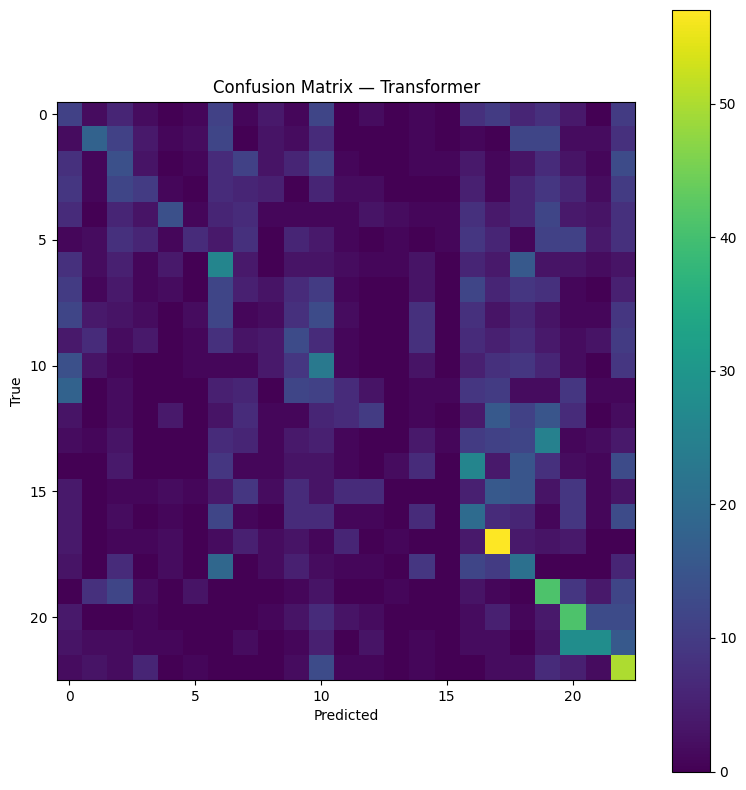

Saved: ../reports/db1/cm_transformer.png


In [10]:
cm = confusion_matrix(y_true_all, y_pred_all)

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("Confusion Matrix — Transformer")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.colorbar(im, ax=ax)
plt.tight_layout()

fig_path = REPORTS_DIR / "cm_transformer.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved:", fig_path)

In [11]:
ckpt_path = MODELS_DIR / "transformer_db1.pt"
meta_path = MODELS_DIR / "transformer_db1_meta.npz"

torch.save(model.state_dict(), ckpt_path)
np.savez_compressed(meta_path, n_features=n_features, n_classes=n_classes)

print("Saved model to:", ckpt_path)
print("Saved meta   to:", meta_path)

Saved model to: ../models/db1/transformer_db1.pt
Saved meta   to: ../models/db1/transformer_db1_meta.npz
